### Using `pylabianca` with `spiketools`
This short example demonstrates how one can use `pylabianca` in tandem with `spiketools`.

In [1]:
import pylabianca as pln

### Creating simulated data
`spiketools` has multiple functions for simulating spike trains, we can use these functions and then turn the simulated spikes into `pylabianca` objects:

In [2]:
from spiketools.sim.trials import sim_trials_poisson

n_trials = 25
rate_pre = 7.5
rate_post = 15

trial_spikes = sim_trials_poisson(n_trials, rate_pre, rate_post)

`spiketools` uses numpy arrays (and lists of such arrays) for almost all operations:

In [3]:
print(type(trial_spikes))
print(type(trial_spikes[0]))

<class 'list'>
<class 'numpy.ndarray'>


In [4]:
trial_spikes[0][:10]

array([-0.77580685, -0.58236213, -0.43342559, -0.39446556, -0.17121901,
        0.03090472,  0.09763637,  0.10404646,  0.32123901,  0.52747708])

We can use `pylabianca.io.from_spiketools()` to convert spiketools numpy data to pylabianca `SpikeEpochs`:

In [5]:
spk_epochs = pln.io.from_spiketools(trial_spikes, kind='trials')

<Axes: title={'center': 'cell = cell000'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

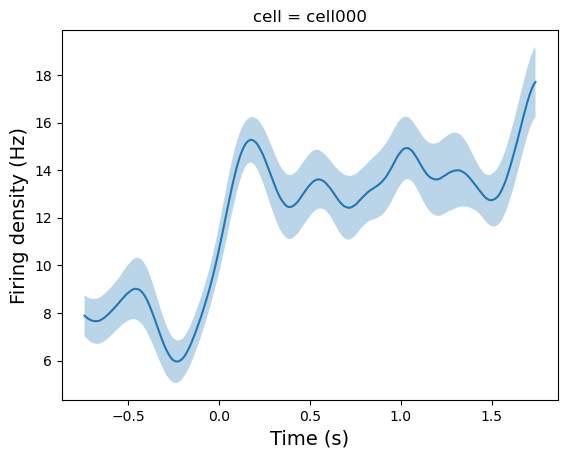

In [6]:
frate = spk_epochs.spike_density(fwhm=0.2)
pln.viz.plot_shaded(frate)

we can simulate another condition by simulating another set of trials with different `rate_post`:

In [7]:
rate_post = 25
trial_spikes2 = sim_trials_poisson(n_trials, rate_pre, rate_post)

In [8]:
spk_epochs = pln.io.from_spiketools(trial_spikes + trial_spikes2, kind='trials')

now we can fill metadata and compare both conditions on one plot:

In [9]:
import pandas as pd

conditions = [0] * 25 + [1] * 25
spk_epochs.metadata = pd.DataFrame(dict(condition=conditions))

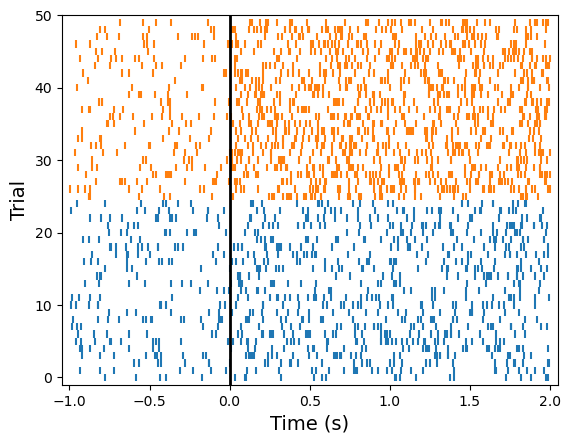

In [13]:
ax = pln.viz.plot_raster(spk_epochs, groupby='condition')
ax.axvline(0., color='k', lw=2.)

<Axes: title={'center': 'cell = cell000'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

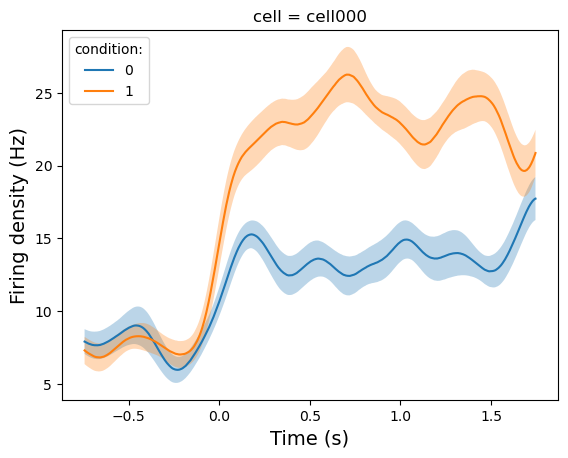

In [10]:
frate = spk_epochs.spike_density(fwhm=0.2)
pln.viz.plot_shaded(frate, groupby='condition')

and perform cluster based test to see if the conditions differ:

In [11]:
n_permutations = 1_000
stat, clusters, pvals = pln.stats.cluster_based_test(
    frate[0], compare='condition', n_permutations=n_permutations)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 436.48it/s]


<Axes: title={'center': 'cell = cell000'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

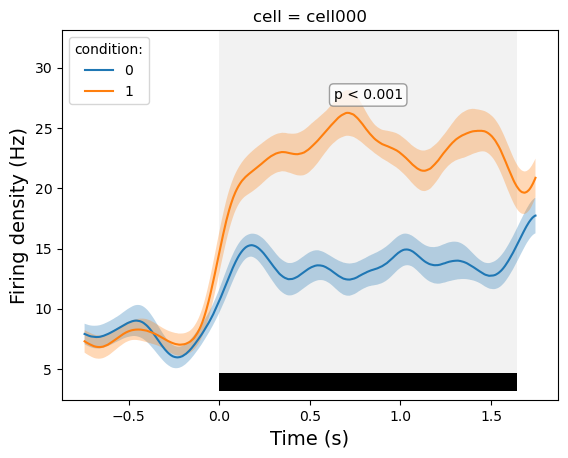

In [12]:
pln.viz.plot_shaded(frate, groupby='condition')
pln.viz.add_highlights(frate, clusters, pvals, min_pval=1/n_permutations)

### Using spiketools functions on SpikeEpochs object
We can also use spiketools functions on pylabianca objects using the `.apply()` method:

In [14]:
from spiketools.measures.spikes import compute_isis, compute_cv

def compute_cv_from_spikes(data):
    isi = compute_isis(data)
    return compute_cv(isi)

cvs = spk_epochs.apply(compute_cv_from_spikes)

the result will be an xarray:

In [15]:
cvs

<xarray.DataArray (cell: 1, trial: 50)>
array([[0.87566858, 0.85873123, 0.83760299, 1.05557854, 1.11331804,
        1.08289964, 0.98349395, 1.45333346, 0.91441272, 0.55268466,
        1.04677084, 1.17615568, 0.80032242, 0.9122545 , 1.52804805,
        1.07200417, 0.80282146, 0.99631529, 0.85432673, 1.4732719 ,
        1.19037452, 1.29649776, 0.76205077, 0.94570606, 1.03327367,
        1.2748918 , 1.1090416 , 1.21251431, 1.4166595 , 1.01259529,
        1.1003769 , 1.09459907, 1.04437496, 1.08550496, 1.12456432,
        1.06876419, 0.90968701, 1.27316426, 1.31754044, 1.17789211,
        1.31396554, 1.64456159, 1.13927875, 1.07882943, 1.03890312,
        1.58321094, 1.21194948, 0.88198091, 1.29926073, 0.98511463]])
Coordinates:
  * trial      (trial) int32 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * cell       (cell) <U7 'cell000'
    condition  (trial) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
Attributes:
    timewindow:  None

because the resulting xarray inherited the condition information, we can now average coefficient of variation by condition:

In [19]:
cvs.groupby('condition').mean()

<xarray.DataArray (cell: 1, condition: 2)>
array([[1.02471671, 1.17596903]])
Coordinates:
  * cell       (cell) <U7 'cell000'
  * condition  (condition) int64 0 1
Attributes:
    timewindow:  None